# ANÁLISIS PREDICTIVO

A continuación se presenta el análisis predictivo. Realizamos una regresión lineal sobre los salarios en el tiempo, y obtuvimos predicciones salariales para 2025

Las 10 industrias con más empresas son:


['Staffing and Recruiting',
 'IT Services and IT Consulting',
 'Hospitals and Health Care',
 'Software Development',
 'Financial Services',
 'Construction',
 'Advertising Services',
 'Non-profit Organizations',
 'Real Estate',
 'Business Consulting and Services']


Los 5 roles más frecuentes dentro de las 10 industrias con más empresas son:


['Sales Manager',
 'Project Manager',
 'Registered Nurse',
 'Administrative Assistant',
 'Executive Assistant']


Pronóstico para el rol 'Sales Manager':


,fecha,demanda_pronosticada
0,2024-04-20,59.063805
1,2024-04-21,56.520882
2,2024-04-22,53.977958
3,2024-04-23,51.435035
4,2024-04-24,48.892111
5,2024-04-25,46.349188
6,2024-04-26,43.806265


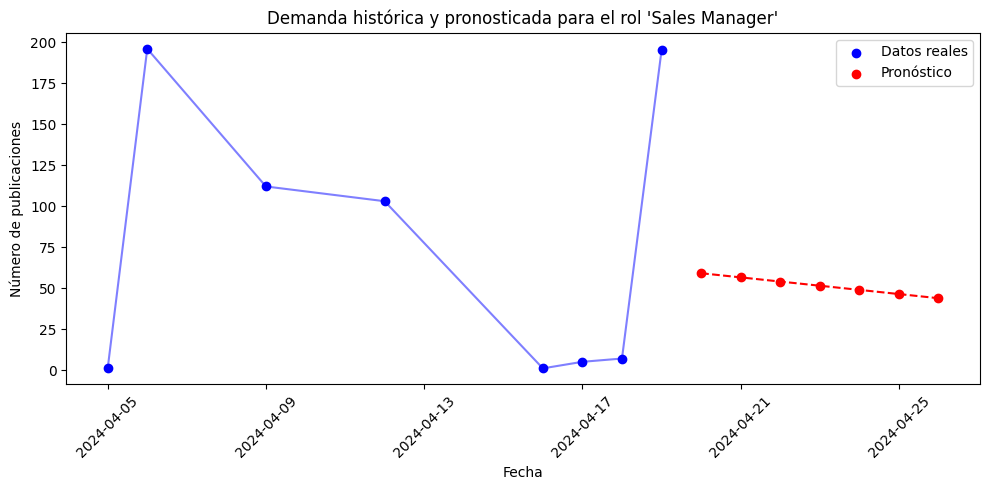


Pronóstico para el rol 'Project Manager':


,fecha,demanda_pronosticada
0,2024-04-20,43.440966
1,2024-04-21,46.016100
2,2024-04-22,48.591234
3,2024-04-23,51.166369
4,2024-04-24,53.741503
5,2024-04-25,56.316637
6,2024-04-26,58.891771


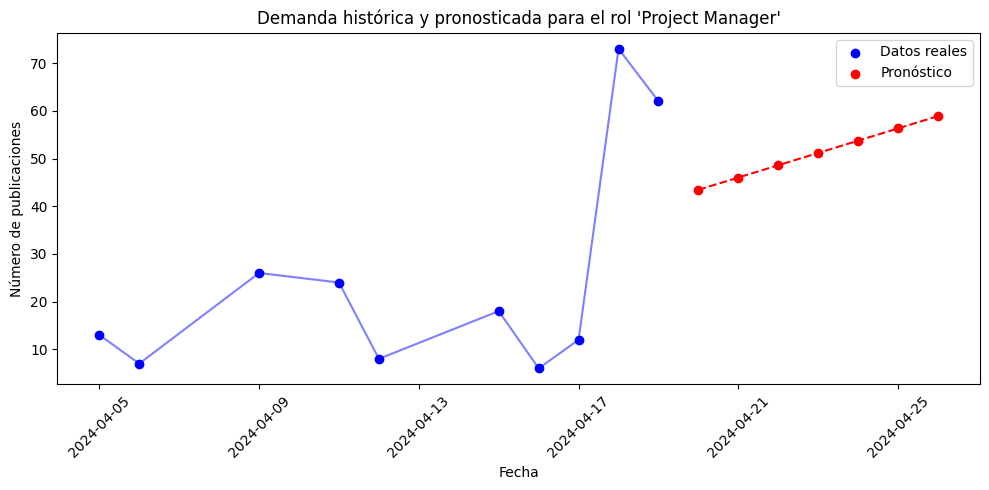


Pronóstico para el rol 'Registered Nurse':


,fecha,demanda_pronosticada
0,2024-04-20,35.508945
1,2024-04-21,37.815742
2,2024-04-22,40.122540
3,2024-04-23,42.429338
4,2024-04-24,44.736136
5,2024-04-25,47.042934
6,2024-04-26,49.349732


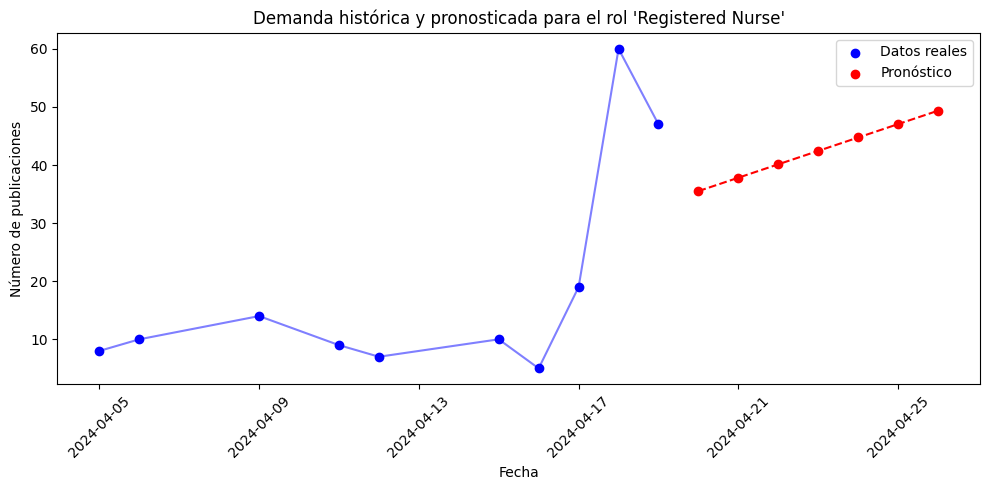


Pronóstico para el rol 'Administrative Assistant':


,fecha,demanda_pronosticada
0,2024-04-20,33.101574
1,2024-04-21,35.420601
2,2024-04-22,37.739628
3,2024-04-23,40.058655
4,2024-04-24,42.377682
5,2024-04-25,44.696710
6,2024-04-26,47.015737


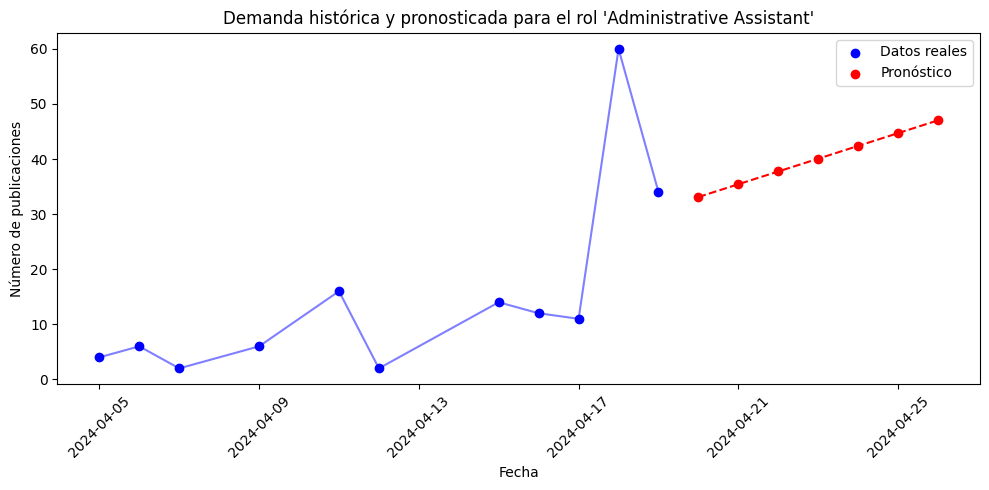


Pronóstico para el rol 'Executive Assistant':


,fecha,demanda_pronosticada
0,2024-04-20,27.663685
1,2024-04-21,29.228086
2,2024-04-22,30.792487
3,2024-04-23,32.356887
4,2024-04-24,33.921288
5,2024-04-25,35.485689
6,2024-04-26,37.050089


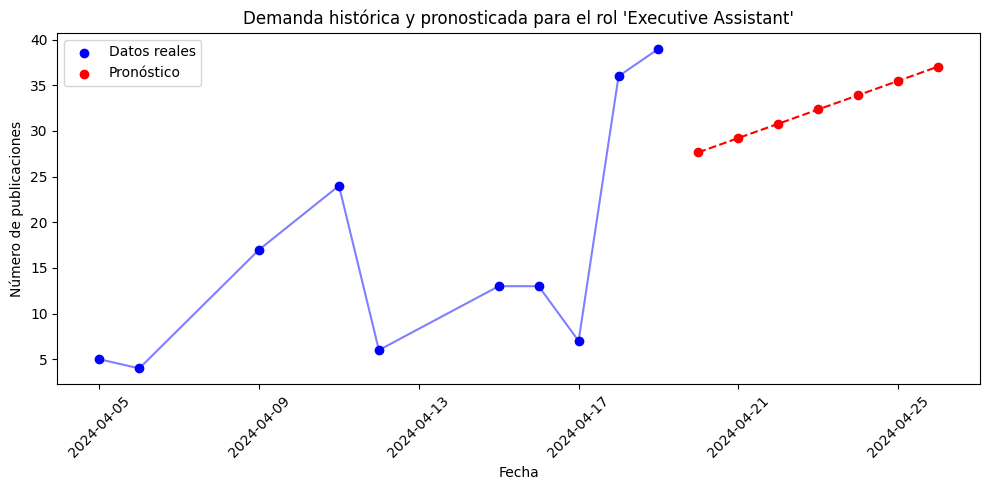

In [17]:
# =============================================================================
# 1)OBTENEMOS DE NUEVO EL TOP 10 INDUSTRIAS CON MAYOR NÚMERO DE EMPRESAS
# =============================================================================
industry_counts = df_company_industries['industry'].value_counts()
top_10_industries = industry_counts.head(10).index.tolist()

print("Las 10 industrias con más empresas son:")
display(top_10_industries)

# =============================================================================
# 2)FILTRAMOS PUBLICACIONES PARA SOLO INCLUIR LAS DE ESAS 10 INDUSTRIAS
# =============================================================================
#Hacemos merge para saber la industria de la compañía que publicó el empleo
df_merged = pd.merge(df_postings, 
                     df_company_industries, 
                     how='left', 
                     on='company_id')

#Nos quedamos únicamente con las filas cuya industria está en el top 10
df_merged_top = df_merged[df_merged['industry'].isin(top_10_industries)].copy()

# =============================================================================
# 3)CREAMOS UNA COLUMNA DE FECHA (SIN HORA) PARA AGRUPAR POR DÍA
# =============================================================================
#Convertimos 'listed_time' a tipo datetime (en milisegundos, si así está almacenado)
df_merged_top['listed_time'] = pd.to_datetime(df_merged_top['listed_time'], unit='ms', errors='coerce')

#Eliminamos registros sin fecha válida
df_merged_top.dropna(subset=['listed_time'], inplace=True)

#Creamos la columna 'listed_date' para agrupar por día
df_merged_top['listed_date'] = df_merged_top['listed_time'].dt.date

# =============================================================================
# 4)AGRUPAMOS PARA VER LA DEMANDA (N° DE PUBLICACIONES) POR FECHA Y POR ROL
# =============================================================================
#Suponiendo que el "título" del rol se encuentra en la columna 'title'
demand_df = df_merged_top.groupby(['listed_date', 'title']).size().reset_index(name='count')

# =============================================================================
# 5)IDENTIFICAMOS LOS ROLES MÁS FRECUENTES EN ESTAS INDUSTRIAS
#    (POR EJEMPLO, TOP 5 O TOP 10 ROLES)
# =============================================================================
role_counts = demand_df.groupby('title')['count'].sum().sort_values(ascending=False)
top_5_roles = role_counts.head(5).index.tolist()  # Puedes ajustar a 10 si deseas

print("\nLos 5 roles más frecuentes dentro de las 10 industrias con más empresas son:")
display(top_5_roles)

# =============================================================================
# 6)PREPARAMOS LA FUNCIÓN PARA PRONOSTICAR DEMANDA DE CADA ROL CON REGRESIÓN LINEAL
# =============================================================================
# =============================================================================
# Función para realizar la regresión lineal con las fórmulas vistas en clase
# =============================================================================
def calcular_regresion_lineal(X, y):
    """
    Calcula los coeficientes A y B para el modelo y = A*x + B,
    usando las fórmulas:
        A = (N * Σ(x_i*y_i) - Σx_i * Σy_i) / (N*Σ(x_i^2) - (Σx_i)^2)
        B = (Σ(x_i^2) * Σy_i - Σx_i * Σ(x_i*y_i)) / (N*Σ(x_i^2) - (Σx_i)^2)
    """
    N = len(X)
    suma_X2 = np.sum(X**2)
    suma_X = np.sum(X)
    suma_XY = np.sum(X * y)
    suma_y = np.sum(y)
    Delta = N * suma_X2 - suma_X**2
    if Delta == 0:
        raise ValueError("Delta es 0, no se puede calcular la regresión.")
    A = (N * suma_XY - suma_X * suma_y) / Delta
    B = (suma_X2 * suma_y - suma_X * suma_XY) / Delta
    return A, B

# =============================================================================
#Función para pronosticar la demanda de un rol utilizando regresión lineal
# =============================================================================
def forecast_role_demand(role_name, df_role, days_to_predict=7):
    """
    Aplica la regresión lineal para predecir la demanda (n° de publicaciones)
    de un 'role_name' en los próximos 'days_to_predict' días.
    
    Parámetros:
      - role_name: Nombre del rol.
      - df_role: DataFrame filtrado para ese rol, con columnas:
                 ['listed_date', 'count'].
      - days_to_predict: Número de días futuros a predecir.
    
    Retorna un DataFrame con las fechas y la demanda pronosticada, además de los
    coeficientes A y B calculados.
    """
    # Ordenamos por fecha
    df_role = df_role.sort_values('listed_date').copy()
    
    # Convertimos la fecha a un índice numérico: 0 para el día mínimo
    df_role['day_index'] = (pd.to_datetime(df_role['listed_date']) - 
                             pd.to_datetime(df_role['listed_date'].min())).dt.days
                             
    # Extraemos los valores para la regresión
    X = df_role['day_index'].values.astype(float)
    y = df_role['count'].values.astype(float)
    
    # Calculamos A y B usando la función manual
    A, B = calcular_regresion_lineal(X, y)
    
    # Último día observado
    last_day = df_role['day_index'].max()
    
    # Predecimos para los próximos 'days_to_predict' días
    future_days = np.arange(last_day + 1, last_day + days_to_predict + 1)
    future_pred = A * future_days + B
    
    # Generamos las fechas correspondientes
    forecast_dates = [pd.to_datetime(df_role['listed_date'].min()) + pd.Timedelta(days=int(d))
                      for d in future_days]
    
    forecast_df = pd.DataFrame({
        'fecha': forecast_dates,
        'demanda_pronosticada': future_pred
    })
    
    return forecast_df, (A, B)


# =============================================================================
# 7)APLIXAMOS EL PRONÓSTICO PARA CADA UNO DE LOS TOP ROLES
# =============================================================================
results = {}

#for role in top_5_roles:
def table_role_forecasts(role):
    #filtrar demand_df para el rol en cuestión
    df_role = demand_df[demand_df['title'] == role].copy()
    
    if len(df_role) < 2:
        #si apenas hay 1 o 2 puntos, no es factible hacer una regresión lineal confiable
        print(f"\nNo hay suficientes datos para pronosticar el rol: {role}")
        return None
    
    forecast_df, model = forecast_role_demand(role, df_role, days_to_predict=7)
    results[role] = forecast_df

    print(f"\nPronóstico para el rol '{role}':")
    display(forecast_df)


# =============================================================================
# 8)VISUALIZACIÓN PARA CADA UNO DE LOS ROLES DEL TOP 5
# =============================================================================
def graph_role_forecasts(role):
    if role not in results:
        print(f"\nNo hay suficientes datos para pronosticar el rol: {role}")
        return None
    
    forecast_df = results[role]
    # Filtrar los datos históricos para el rol actual
    df_hist = demand_df[demand_df['title'] == role].copy()
    df_hist['listed_date'] = pd.to_datetime(df_hist['listed_date'])
    df_hist = df_hist.sort_values('listed_date')
    df_hist['day_index'] = (df_hist['listed_date'] - df_hist['listed_date'].min()).dt.days
    
    plt.figure(figsize=(10, 5))
    plt.scatter(df_hist['listed_date'], df_hist['count'], color='blue', label='Datos reales')
    plt.plot(df_hist['listed_date'], df_hist['count'], color='blue', alpha=0.5)
    plt.scatter(forecast_df['fecha'], forecast_df['demanda_pronosticada'], 
                color='red', label='Pronóstico')
    plt.plot(forecast_df['fecha'], forecast_df['demanda_pronosticada'], 
             color='red', linestyle='--')
    plt.title(f"Demanda histórica y pronosticada para el rol '{role}'")
    plt.xlabel("Fecha")
    plt.ylabel("Número de publicaciones")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

for role in top_5_roles:
    table_role_forecasts(role)
    graph_role_forecasts(role)

Como vimos anteriormente en las 10 industrias con mayor cantidad de empresas, existe una alta actividad en áreas de reclutamiento, tecnología, salud y servicios financieros, lo que sugiere que estos sectores están altamente competitivos y son de gran relevancia en el mercado laboral actual.
Los 5 roles más frecuentes dentro de estas industrias son:
-  Sales Manager
-  Project Manager
-  Registered Nurse
-  Administrative Assistant
-  Executive Assistant

Esta distribución muestra que los puestos gerenciales (Sales Manager y Project Manager) y de soporte administrativo (Administrative Assistant y Executive Assistant) tienen una alta presencia, junto con un rol técnico-especializado en salud (Registered Nurse). Esto puede reflejar tanto la necesidad de liderazgo y coordinación en sectores dinámicos como la demanda constante en el área de la salud.\
Utilizando una regresión lineal simple, se han generado las siguientes proyecciones para un horizonte de 7 días:\
Sales Manager: La proyección muestra una tendencia descendente; pues el 20 de abril de 2024 se pronostican 59.06 publicaciones, mientras que el 26 de abril se pronostican 43.81.
La pendiente negativa obtenida en la regresión indica que, durante el periodo analizado, la demanda para el rol de Sales Manager está en declive. Esto podría deberse a factores como saturación del mercado, cambios en la estrategia de contratación o una disminución temporal en las necesidades de ventas.\
Project Manager: La demanda proyectada crece de 43.44 a 58.89 publicaciones en el mismo intervalo. Una pendiente positiva sugiere que hay una tendencia creciente en la contratación de Project Manager, lo que podría reflejar una mayor inversión en gestión de proyectos o la necesidad de coordinación en iniciativas empresariales en sectores tecnológicos o consultoría.
Registered Nurse: Se observa un aumento gradual de 35.51 a 49.35 publicaciones. Este comportamiento es coherente con el sector salud, donde un crecimiento en la demanda de enfermeros puede estar impulsado por el aumento de la población, cambios en la política sanitaria o la expansión de servicios hospitalarios.\
Administrative Assistant: La proyección pasa de 33.10 a 47.02 publicaciones. La tendencia ascendente indica una mayor necesidad de personal de apoyo administrativo, lo que puede ser consecuencia de la expansión de las operaciones empresariales en las industrias analizadas.\
Executive Assistant: La demanda se incrementa de 27.66 a 37.05 publicaciones. Similar a los asistentes administrativos, la demanda creciente de Executive Assistant puede reflejar la necesidad de soporte especializado para altos ejecutivos en empresas con estructuras organizacionales complejas.